In [ ]:
!unzip /content/drive/MyDrive/Dataset/biodegradable_or_not.zip

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory('TRAIN',
                                                            shuffle=True,
                                                            subset='training',
                                                            seed=123,
                                                            validation_split=0.3,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 59922 files belonging to 2 classes.
Using 41946 files for training.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory('TRAIN',
                                                            shuffle=True,
                                                            subset='validation',
                                                            seed=123,
                                                            validation_split=0.3,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 59922 files belonging to 2 classes.
Using 17976 files for validation.


In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory('TEST',
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 16726 files belonging to 2 classes.


In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

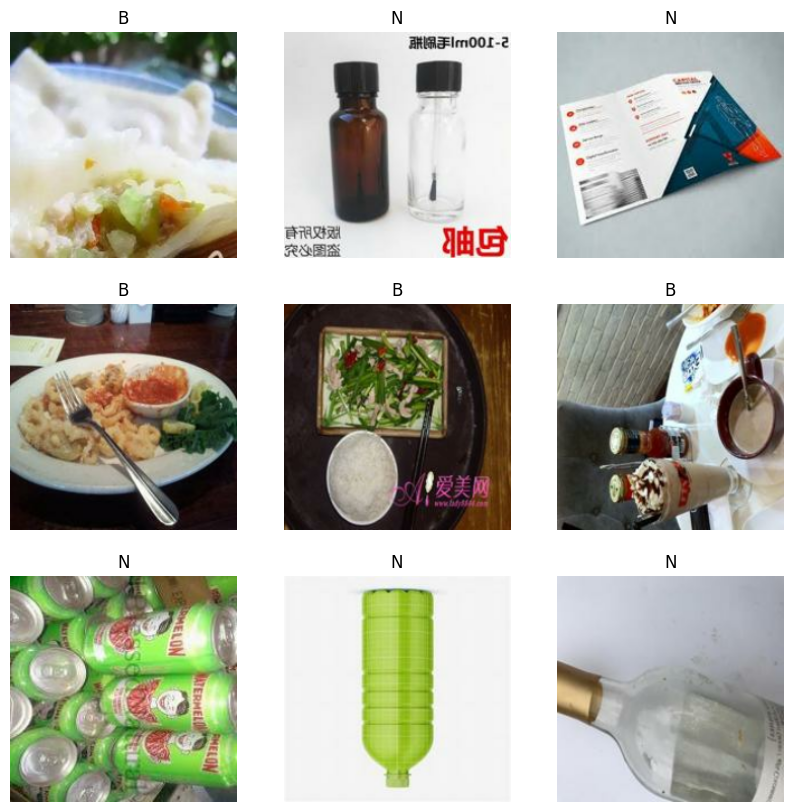

In [9]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
class_names

['B', 'N']

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 419
Number of test batches: 104


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [13]:

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

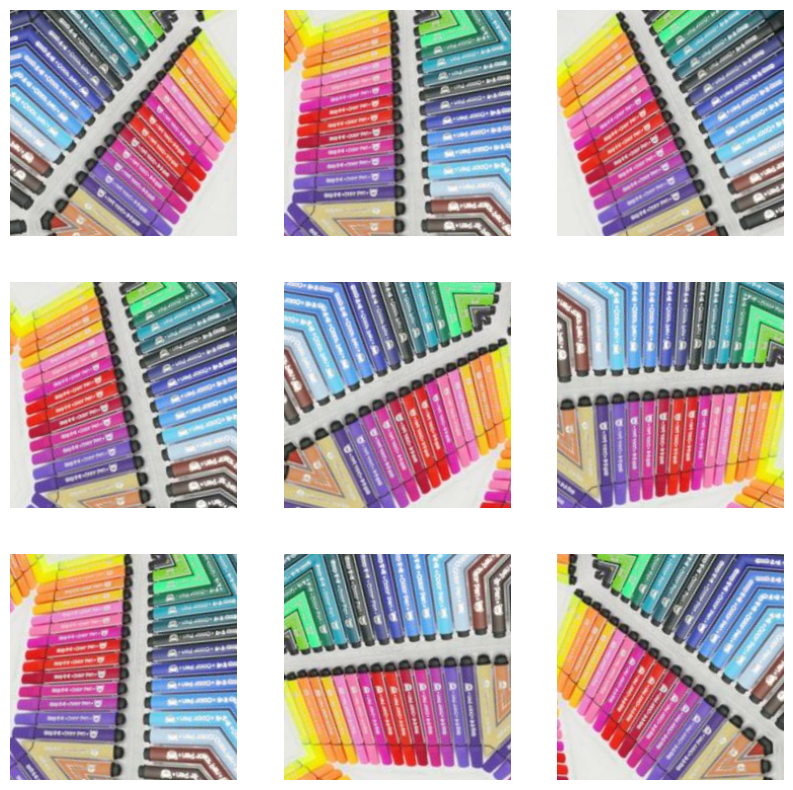

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [15]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [16]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [17]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [18]:

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 7, 7, 1280)


In [19]:
base_model.trainable = False

In [20]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [22]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [23]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [26]:
len(model.trainable_variables)

2

In [27]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

419/419 [==============================] - 25s 49ms/step - loss: 0.9503 - accuracy: 0.3560


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.95
initial accuracy: 0.36


In [29]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
1311/1311 [==============================] - 115s 84ms/step - loss: 0.2517 - accuracy: 0.8873 - val_loss: 0.2351 - val_accuracy: 0.9175
Epoch 2/10
1311/1311 [==============================] - 87s 66ms/step - loss: 0.1319 - accuracy: 0.9510 - val_loss: 0.1915 - val_accuracy: 0.9341
Epoch 3/10
1311/1311 [==============================] - 88s 67ms/step - loss: 0.1151 - accuracy: 0.9580 - val_loss: 0.1721 - val_accuracy: 0.9406
Epoch 4/10
1311/1311 [==============================] - 88s 67ms/step - loss: 0.1080 - accuracy: 0.9597 - val_loss: 0.1672 - val_accuracy: 0.9432
Epoch 5/10
1311/1311 [==============================] - 88s 67ms/step - loss: 0.1040 - accuracy: 0.9622 - val_loss: 0.1610 - val_accuracy: 0.9448
Epoch 6/10
1311/1311 [==============================] - 86s 65ms/step - loss: 0.1007 - accuracy: 0.9629 - val_loss: 0.1616 - val_accuracy: 0.9463
Epoch 7/10
1311/1311 [==============================] - 107s 81ms/step - loss: 0.0976 - accuracy: 0.9650 - val_loss: 0.1680

In [30]:
!pip install mplcyberpunk

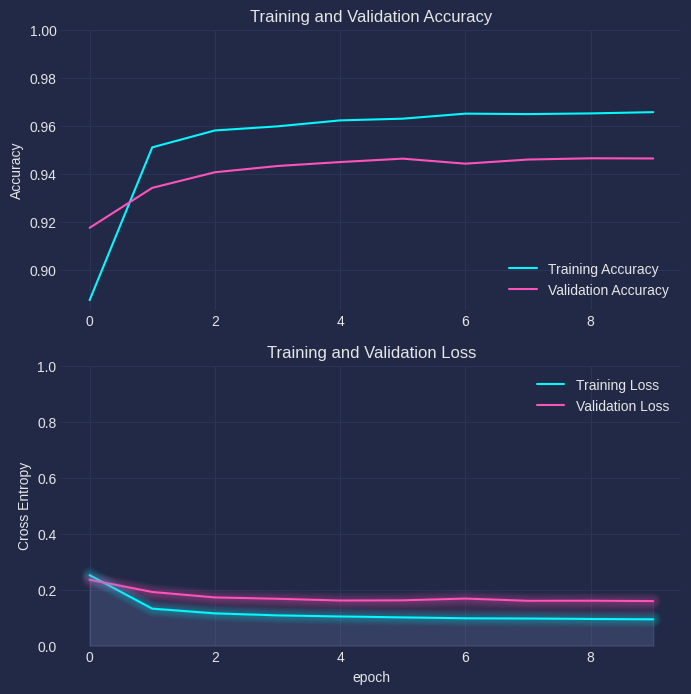

In [31]:
import mplcyberpunk
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.style.use("cyberpunk")
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
mplcyberpunk.add_glow_effects()
plt.show()

In [32]:
base_model.trainable = True

In [33]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [34]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
base_model.summary()

In [36]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [38]:
len(model.trainable_variables)

56

In [39]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
1311/1311 [==============================] - 131s 90ms/step - loss: 0.0877 - accuracy: 0.9685 - val_loss: 0.1605 - val_accuracy: 0.9467
Epoch 11/20
1311/1311 [==============================] - 114s 87ms/step - loss: 0.0716 - accuracy: 0.9748 - val_loss: 0.2294 - val_accuracy: 0.9266
Epoch 12/20
1311/1311 [==============================] - 114s 87ms/step - loss: 0.0611 - accuracy: 0.9779 - val_loss: 0.1680 - val_accuracy: 0.9451
Epoch 13/20
1311/1311 [==============================] - 114s 87ms/step - loss: 0.0514 - accuracy: 0.9819 - val_loss: 0.1819 - val_accuracy: 0.9436
Epoch 14/20
1311/1311 [==============================] - 115s 88ms/step - loss: 0.0480 - accuracy: 0.9831 - val_loss: 0.3396 - val_accuracy: 0.9042
Epoch 15/20
1311/1311 [==============================] - 114s 87ms/step - loss: 0.0417 - accuracy: 0.9850 - val_loss: 0.2256 - val_accuracy: 0.9358
Epoch 16/20
1311/1311 [==============================] - 112s 86ms/step - loss: 0.0397 - accuracy: 0.9865 - val_

In [40]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

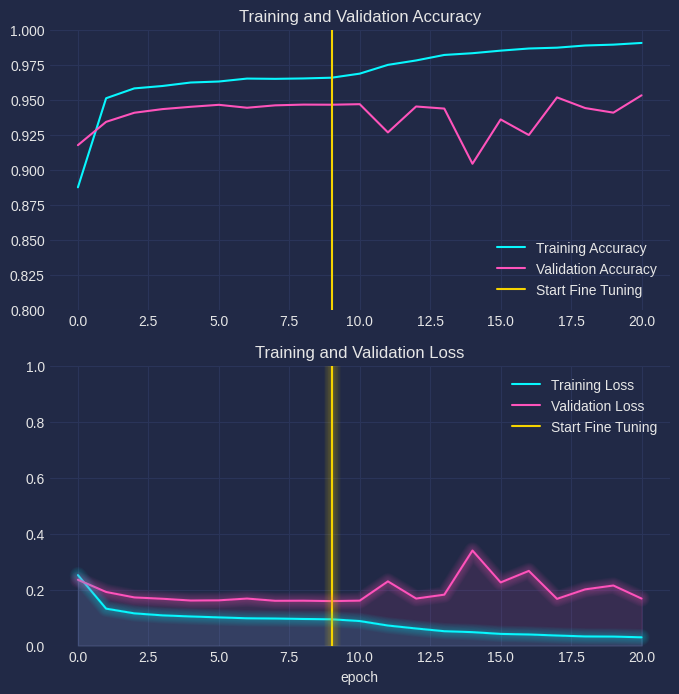

In [41]:
plt.style.use("cyberpunk")
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
mplcyberpunk.add_glow_effects()
plt.show()

In [42]:
model.save('B_Or_N.h5')

In [43]:
loss, accuracy = model.evaluate(test_dataset)
print('Test loss :', loss)
print('Test accuracy :', accuracy)

104/104 [==============================] - 5s 44ms/step - loss: 0.1618 - accuracy: 0.9537
Test loss : 0.16178320348262787
Test accuracy : 0.9537259340286255


Predictions:
 [0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0]
Labels:
 [0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0]


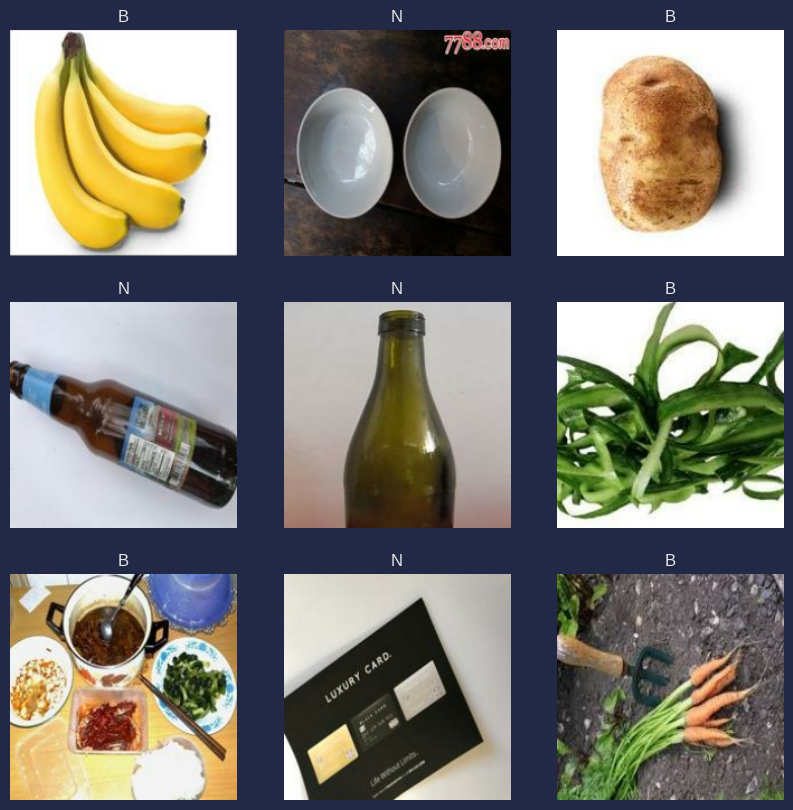

In [44]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [3]:
test_model =keras.models.load_model('B_Or_N.h5')

In [4]:
import cv2

In [11]:
img = cv2.imread("TEST_NBIODEG_ORI_10.jpg")
img = cv2.resize(img,(224,224))

In [17]:
image = tf.expand_dims(img,axis=0)

In [18]:
image

<tf.Tensor: shape=(1, 224, 224, 3), dtype=uint8, numpy=
array([[[[ 80, 165, 121],
         [ 61, 146, 101],
         [ 56, 138,  93],
         ...,
         [ 40, 113,  65],
         [ 55, 125,  78],
         [ 37, 107,  60]],

        [[ 80, 165, 121],
         [ 75, 160, 115],
         [ 53, 136,  91],
         ...,
         [ 52, 123,  76],
         [ 56, 126,  79],
         [ 25,  95,  48]],

        [[ 83, 171, 125],
         [ 93, 178, 133],
         [ 55, 138,  93],
         ...,
         [ 52, 123,  77],
         [ 45, 115,  68],
         [ 16,  85,  38]],

        ...,

        [[ 44, 140,  92],
         [ 54, 147,  97],
         [ 49, 135,  86],
         ...,
         [ 28, 133,  76],
         [ 27, 135,  77],
         [ 41, 151,  93]],

        [[ 31, 126,  76],
         [ 65, 158, 107],
         [ 79, 166, 116],
         ...,
         [ 17, 123,  64],
         [ 26, 135,  76],
         [ 31, 141,  82]],

        [[  3,  98,  47],
         [ 61, 153, 102],
         [ 90, 177

In [21]:
ans = test_model.predict(image)

1/1 [==============================] - 0s 132ms/step


In [20]:
classes = ["B","N"]

In [25]:
predictions = tf.nn.sigmoid(ans)
predictions

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.83749944]], dtype=float32)>

In [26]:
predictions = tf.where(predictions < 0.5, 0, 1)
predictions

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1]])>

In [35]:
predictions.numpy()[0][0]

1

In [ ]:
test_model.summary()

In [ ]:
# import tensorflow as tf
# model = tf.keras.models.load_model("/content/drive/MyDrive/B_or_NOT.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("/content/drive/MyDrive/model.tflite", 'wb') as f:
  f.write(tflite_model)

In [ ]:
Test_model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(320, kernel_size=(3, 3),kernel_initializer='HeUniform', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(64, kernel_size=(3, 3),kernel_initializer='HeUniform', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(128, kernel_size=(3, 3),kernel_initializer='HeUniform', activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(256, kernel_size=(3, 3),kernel_initializer='HeUniform', activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024,kernel_initializer='HeNormal', activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(512,kernel_initializer='HeNormal', activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(len(class_names),activation='softmax')
])